### Load Arctic DEM

Notebook contents 
* Take a look at the Arctic DEM downloaded in `hdd/snow_hydrology/DEMs/`
* Develop processing workflow 

created by Cassie Lumbrazo\
last updated: April 2025\
run location: UAS linux\
python environment: **rasterio**

In [9]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import scipy

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

import rioxarray
import rasterio 
import cfgrib
import os

from rasterio.warp import transform_bounds

In [2]:
pwd

'/home/cassie/python/repos/juneau_data_analysis'

In [ ]:
filepath = '/hdd/snow_hydrology/DEMs/ArcticDEM/'
filename =  '40_05_2_2_2m_v4.1_dem.tif'

# open the DEM 
dem = rioxarray.open_rasterio(os.path.join(filepath, filename), masked=True)
dem

<xarray.DataArray (band: 1, y: 25100, x: 25100)> Size: 3GB
[630010000 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 201kB -3.55e+06 -3.55e+06 ... -3.5e+06 -3.5e+06
  * y            (y) float64 201kB 99.0 97.0 95.0 ... -5.01e+04 -5.01e+04
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        1652.4415283203
    STATISTICS_MEAN:           295.53387922007
    STATISTICS_MINIMUM:        -0.30414265394211
    STATISTICS_STDDEV:         359.77932597602
    STATISTICS_VALID_PERCENT:  99.999
    scale_factor:              1.0
    add_offset:                0.0

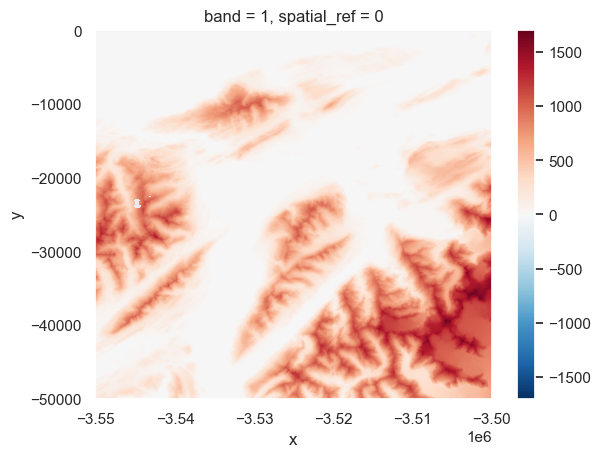

In [5]:
dem.plot()

In [ ]:
dem.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / NSIDC Sea Ice Polar Stereographic North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",70],PARAMETER["central_meridian",-45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH],AUTHORITY["EPSG","3413"]]')

So, the DEM is in EPSG: 3413 (NSIDC Sea Ice Polar Stereographic North), but my bounding box coordinates are in EPSG:4326 (latitude/longitude).\
Let's reproject the DEM before clipping.

In [ ]:
# Reproject the DEM to EPSG:4326
# dem.rio.write_crs("EPSG:4326", inplace=True) # this is writing the crs
# dem_wgs84 = dem.rio.reproject("EPSG:4326", resolution=dem.rio.resolution())

dem_wgs84 = dem.rio.reproject("EPSG:4326")
dem_wgs84.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [ ]:
dem_wgs84

<xarray.DataArray (band: 1, y: 16599, x: 31500)> Size: 2GB
array([[[3.609375 , 3.609375 , 3.609375 , ...,       nan,       nan,
               nan],
        [3.6015625, 3.6015625, 3.6015625, ...,       nan,       nan,
               nan],
        [3.6015625, 3.6015625, 3.6015625, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], shape=(1, 16599, 31500), dtype=float32)
Coordinates:
  * x            (x) float64 252kB -135.0 -135.0 -135.0 ... -134.2 -134.2 -134.2
  * y            (y) float64 133kB 58.48 58.48 58.48 58.48 ... 58.05 58.05 58.05
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        1652.4415283203
    STATISTICS_MEAN:           295.53387922007
    STATISTICS_MINIMUM:        -0.30414265394211
    STATISTICS_STDDEV:         359.77932597602
    STATISTICS_VALID_PERCENT:  99.999
    scale_factor:              1.0
    add_offset:                0.0

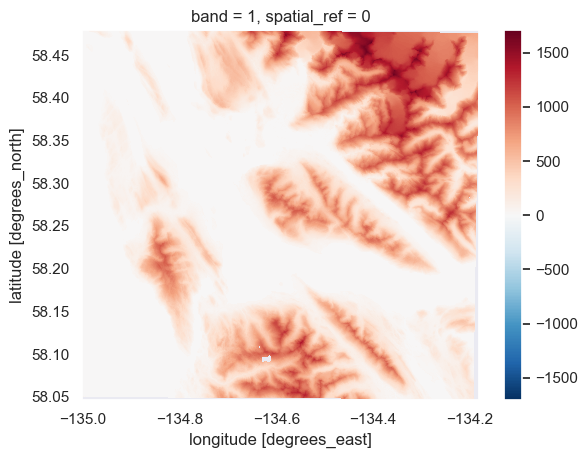

In [ ]:
dem_wgs84.plot()

In [ ]:
# we need to clip the arctic dem to the region around Juneau 
# hrrrak_juneau_bounding_box = "-134.964:-133.893 58.077:58.603" # Simple bounding box for Juneau, Alaska

# Define bounding box (xmin, xmax, ymin, ymax)
xmin, xmax = -134.964, -133.893
ymin, ymax = 58.077, 58.603

# Clip the DEM
dem_juneau = dem_wgs84.rio.clip_box(minx=xmin, maxx=xmax, miny=ymin, maxy=ymax)

# Save the clipped DEM (optional)
dem_juneau.rio.to_raster("/hdd/snow_hydrology/DEMs/ArcticDEM/dem_clipped_juneau.tif")

dem_juneau

<xarray.DataArray (band: 1, y: 15416, x: 30058)> Size: 2GB
array([[[89.60156  , 89.78906  , 89.78906  , ...,        nan,
                nan,        nan],
        [89.75781  , 89.96094  , 89.96094  , ...,        nan,
                nan,        nan],
        [90.046875 , 90.296875 , 90.296875 , ...,        nan,
                nan,        nan],
        ...,
        [ 2.7734375,  2.7734375,  2.7734375, ...,        nan,
                nan,        nan],
        [ 2.7734375,  2.7734375,  2.7734375, ...,        nan,
                nan,        nan],
        [ 2.7734375,  2.7734375,  2.7734375, ...,        nan,
                nan,        nan]]], shape=(1, 15416, 30058), dtype=float32)
Coordinates:
  * x            (x) float64 240kB -135.0 -135.0 -135.0 ... -134.2 -134.2 -134.2
  * y            (y) float64 123kB 58.48 58.48 58.48 58.48 ... 58.08 58.08 58.08
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        1652.4415283203
    STATISTICS_MEAN:           295.53387922007
    STATISTICS_MINIMUM:        -0.30414265394211
    STATISTICS_STDDEV:         359.77932597602
    STATISTICS_VALID_PERCENT:  99.999
    scale_factor:              1.0
    add_offset:                0.0

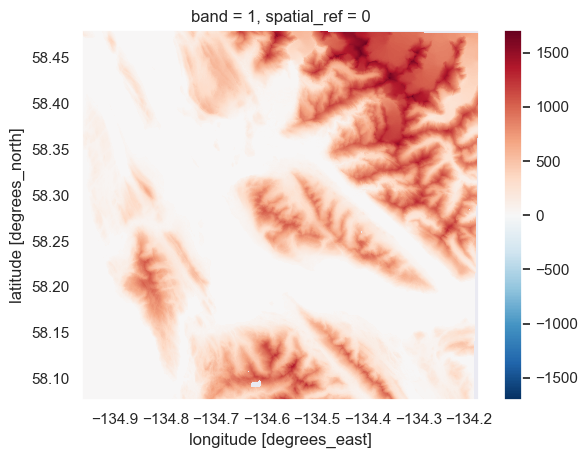

In [20]:
dem_juneau.plot()

Some other code if things are going slow, 

In [22]:
dem_clipped = dem_juneau.copy()

In [ ]:
# if the resulting dataset has a lot of nan 
# dem_clipped = dem_clipped.where(~dem_clipped.isnull())

# or downsample the DEM to reduce the resolution for visualization 
dem_clipped_coarse = dem_clipped.coarsen(x=2, y=2, boundary="trim").mean()
dem_clipped_coarse.plot()

# or convert to float32 to save memory
dem_clipped = dem_clipped.astype("float32")

In [ ]:
# or use im show instead of plot 
plt.imshow(dem_clipped[0], cmap="terrain", origin="upper")
plt.colorbar(label="Elevation (m)")
plt.show()

## Other files in the folder?

In [ ]:
filename =  '40_05_2_2_2m_v4.1_dem_UTM.tif'

# open the DEM 
dem_utm = rioxarray.open_rasterio(os.path.join(filepath, filename), masked=True)
dem_utm

<xarray.DataArray (band: 1, y: 25127, x: 25127)> Size: 3GB
[631366129 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 201kB 4.999e+05 4.999e+05 ... 5.478e+05 5.478e+05
  * y            (y) float64 201kB 6.482e+06 6.482e+06 ... 6.434e+06 6.434e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

: 

In [ ]:
dem_utm.plot()

In [ ]:
dem_utm.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 8N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-135],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32608"]]')